In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
def panorama_to_plane(image_path, FOV, output_size, yaw, pitch):
    erp = cv2.cvtcolor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    erp_width, erp_height, _ = erp.shape

    # spherical coordinate system requires radians 
    yaw_radian = np.radians(yaw)
    pitch_radian = np.radians(pitch)
    output_image = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)
    W, H, _ = output_image.shape 
    f = (0.5*W)/np.tan(np.radians(FOV)/2)
    print(f'focal length is {f}')

    for u in tqdm(range(W)):
        for v in range(H):
            x = u - W * 0.5
            y = H * 0.5 - v
            z = f
            theta, phi = map_to_sphere(x, y, z, yaw_radian, pitch_radian)
            U = phi * erp_width / (2 * np.pi)
            V = theta * erp_height / np.pi 
            U, V = int(np.clip(U, 0, erp_width -1)) , int(np.clip(V, 0, erp_height -1))

            color = interpolate_color(U, V, np.array(erp))

            output_image[u, v] = color
    
    return output_image



- In the above function  the small `u,v` represents the coordinates in the tangential projected viewport `uv` and the capital `U,V` represents the coordinates in the ERP image.

- We orient the viewport as if it were a tangent to a sphere at the north pole, but at a distance `f` from the center of the sphere.

- In the panorama-to-plane conversion process, a key-step involves calculating the focal length, `f` which is derived from the field of view `FOV`, and the width of the output image, `W` . The focal length is crucial because it determines the perspective scale of the image priojection from spherical to a flat plane. 

- To find the focal length we use an empirical formula that takes the half-width of the output image and divides it by the tangent of half the field of view (converted to radians).

- Once we have the Cartesian coordinates, we pass them to the map_to_sphere function along with the yaw and the pitch angles converted to radians. This function will map our Cartesian coordinates `(x, y, z)` onto the sphere, returning the spherical coordinates `(theta, phi)`. This mapping is akin to projecting the flat image onto a sphere, and we’ll use these spherical coordinates to sample the correct pixels from the original panoramic image. 

- This would be an essential step in converting a panorama into a standard view because it allows us to consider the perspective and distortion that comes from viewing a spherical image in a rectangular frame `(the infamous ERP)`. 

- The resulting angles theta and phi will be used to find the corresponding points on the original panoramic image that we need to sample to construct our output image

- Intuitively, we know that the point height will be proportional to the theta  and the width will be proportional to phi  thus we have `U = phi x erp_width/ 2*pi`, `V = theta x erp_height / pi`


In [3]:
from PIL import Image
import numpy as np
from scipy.ndimage import map_coordinates
from tqdm import tqdm

def calculate_bbox_center(bbox):
    x, y, w, h = bbox
    cx = x + w / 2
    cy = y + h / 2
    return int(cx), int(cy)

def calculate_projection_params(bbox, img_width, img_height):
    cx, cy = calculate_bbox_center(bbox)
    
    # Horizontal rotation (longitude)

    rotate_x = 360 * (cx / img_width) - 180 # Convert to degrees centered at 0
    
    # Vertical rotation (latitude)
    rotate_y = (cy / img_height) * 180  # Convert to degrees centered at 0

    return rotate_x, rotate_y


def map_to_sphere(x, y, z, yaw_radian, pitch_radian):


    theta = np.arccos(z / np.sqrt(x ** 2 + y ** 2 + z ** 2))
    phi = np.arctan2(y, x)

    # Apply rotation transformations here
    theta_prime = np.arccos(np.sin(theta) * np.sin(phi) * np.sin(pitch_radian) +
                            np.cos(theta) * np.cos(pitch_radian))

    phi_prime = np.arctan2(np.sin(theta) * np.sin(phi) * np.cos(pitch_radian) -
                           np.cos(theta) * np.sin(pitch_radian),
                           np.sin(theta) * np.cos(phi))
    phi_prime += yaw_radian
    phi_prime = phi_prime % (2 * np.pi)

    return theta_prime.flatten(), phi_prime.flatten()


def interpolate_color(coords, img, method='bilinear'):
    order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
    red = map_coordinates(img[:, :, 0], coords, order=order, mode='reflect')
    green = map_coordinates(img[:, :, 1], coords, order=order, mode='reflect')
    blue = map_coordinates(img[:, :, 2], coords, order=order, mode='reflect')
    return np.stack((red, green, blue), axis=-1)


def panorama_to_plane(panorama_path, FOV, output_size, bbox_coords):
    panorama = Image.open(panorama_path).convert('RGB')
    pano_width, pano_height = panorama.size
    pano_array = np.array(panorama)
    yaw, pitch = calculate_projection_params(bbox_coords, pano_width, pano_height)
    yaw_radian = np.radians(yaw)
    pitch_radian = np.radians(pitch)

    W, H = output_size
    f = (0.5 * W) / np.tan(np.radians(FOV) / 2)

    u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')

    x = u - W / 2
    y = H / 2 - v
    z = f

    theta, phi = map_to_sphere(x, y, z, yaw_radian, pitch_radian)

    U = phi * pano_width / (2 * np.pi)
    V = theta * pano_height / np.pi

    U, V = U.flatten(), V.flatten()
    coords = np.vstack((V, U))

    colors = interpolate_color(coords, pano_array)
    output_image = Image.fromarray(colors.reshape((H, W, 3)).astype('uint8'), 'RGB')

    return output_image


bbox_coords = [1920.0 , 1761.5, 3840, 317]
erp_image_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0115/image/000063.jpg'


output_image = panorama_to_plane(erp_image_path, 90, (320, 320), bbox_coords)
output_image.show()

[(479.99999999999994, 1543.846510050617), (1440.0, 1543.846510050617), (3360.0, 1543.846510050617), (2400.0, 1543.846510050617)]


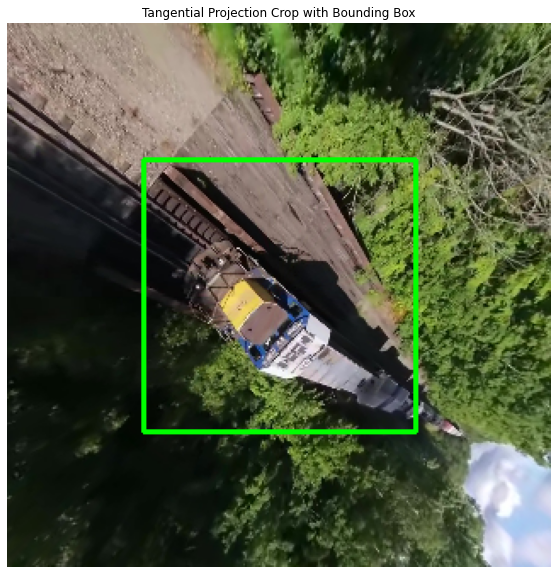

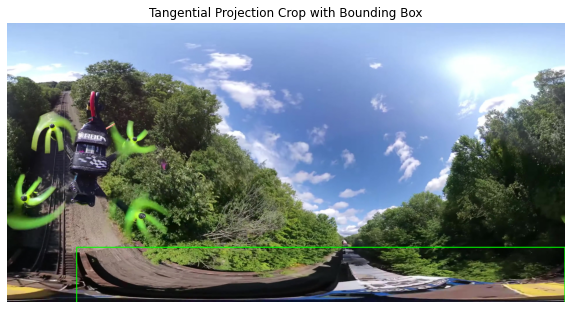

In [5]:
import numpy as np
from scipy.ndimage import map_coordinates
from typing import Tuple, List

class TangentialProjector:
    def __init__(self, erp_img: np.ndarray, FOV: float, output_size: Tuple[int, int], bbox_coords:Tuple[int, int, int, int]):
        """
        Initializes the TangentialProjector.

        :param erp_img: Equirectangular projection image (height, width, channels)
        :param FOV: Field of view for the projection in degrees
        :param output_size: Output size as (width, height)
        :param bbox_coords: Bounding box coordinates as (x, y, width, height)
        """
        self.FOV = FOV
        self.output_size = output_size
        self.bbox_coords = bbox_coords
        self.erp = erp_img
        self.erp_height, self.erp_width, _ = self.erp.shape
        self.yaw_radian, self.pitch_radian = self._calculate_projection_params()

    def _calculate_bbox_center(self) -> Tuple[int, int]:
        x, y, w, h = self.bbox_coords
        cx = x + w / 2
        cy = y + h / 2
        return int(cx), int(cy)

    def _calculate_projection_params(self) -> Tuple[float, float]:
        cx, cy = self._calculate_bbox_center()
        rotate_x = 360 * (cx / self.erp_width) - 180
        rotate_y = (cy / self.erp_height) * 180
        return np.radians(rotate_x), np.radians(rotate_y)

    def _map_to_sphere(self, x: np.ndarray, y: np.ndarray, z: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        theta = np.arccos(z / norm)
        phi = np.arctan2(y, x)

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        sin_pitch = np.sin(self.pitch_radian)
        cos_pitch = np.cos(self.pitch_radian)

        theta_prime = np.arccos(sin_theta * sin_phi * sin_pitch + cos_theta * cos_pitch)
        phi_prime = np.arctan2(sin_theta * sin_phi * cos_pitch - cos_theta * sin_pitch, sin_theta * cos_phi)
        phi_prime = (phi_prime + self.yaw_radian) % (2 * np.pi)

        return theta_prime, phi_prime

    def _interpolate_color(self, coords: np.ndarray, method: str = 'bilinear') -> np.ndarray:
        order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
        red = map_coordinates(self.erp[:, :, 2], coords, order=order, mode='reflect')
        green = map_coordinates(self.erp[:, :, 1], coords, order=order, mode='reflect')
        blue = map_coordinates(self.erp[:, :, 0], coords, order=order, mode='reflect')
        return np.stack((blue, green, red), axis=-1)

    def project(self) -> np.ndarray:
        """
        Projects the ERP image to a tangent plane.

        :return: Tangent plane image as a NumPy array.
        """
        W, H = self.output_size
        f = (0.5 * W) / np.tan(np.radians(self.FOV) / 2)

        u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
        x = u - W / 2
        y = H / 2 - v
        z = f

        theta, phi = self._map_to_sphere(x, y, z)

        U = phi * self.erp_width / (2 * np.pi)
        V = theta * self.erp_height / np.pi

        U, V = U.flatten(), V.flatten()
        coords = np.vstack((V, U))

        colors = self._interpolate_color(coords)
        output_image = colors.reshape((H, W, 3)).astype('uint8')

        return output_image

    def _plane_to_sphere(self, u: float, v: float) -> Tuple[np.ndarray, np.ndarray]:
        W, H = self.output_size
        f = (0.5 * W) / np.tan(np.radians(self.FOV) / 2)
        x = u - W / 2
        y = H / 2 - v
        z = f
        return self._map_to_sphere(x, y, z)

    def _sphere_to_panorama(self, theta: np.ndarray, phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        U = phi * self.erp_width / (2 * np.pi)
        V = theta * self.erp_height / np.pi
        return U, V

    def inverse_project(self, plane_coords: List[Tuple[float, float]]) -> List[Tuple[float, float]]:
        """
        Maps points in the tangential projection back to the ERP.

        :param plane_coords: List of points in the tangential plane as (u, v)
        :return: List of corresponding points in the ERP as (U, V)
        """
        pano_coords = []
        for u, v in plane_coords:
            theta, phi = self._plane_to_sphere(u, v)
            U, V = self._sphere_to_panorama(theta, phi)
            pano_coords.append((U, V))
        return pano_coords


# Usage example
bbox_coords = [1920.0, 1761.5, 3840, 317]
erp_image_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0115/image/000063.jpg'
erp_image =  cv2.cvtColor(cv2.imread(erp_image_path), cv2.COLOR_BGR2RGB)
output_size = (320, 320)
FOV = 90

# Create the PanoramaProjector object
projector = TangentialProjector(erp_image, FOV, output_size, bbox_coords)

# Generate the plane image from the panorama
output_image = projector.project()

# Function to draw bounding box on the image
def draw_bbox(image, bbox, color=(255, 0, 0), thickness=2):
    x, y, w, h = map(int, bbox)
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), color, thickness)
    return image_with_bbox

# Example bounding box coordinates detected in the Tangential Projection Crop
x, y, w, h = [80, 80, 160, 160]  # Example coordinates (x, y, w, h)

# Draw the bounding box on the Tangential Projection Crop
projected_crop_with_bbox = draw_bbox(output_image, (x, y, w, h), color=(0, 255, 0), thickness=2)


plane_coords = [(x, y), (x + w, y), (x, y + h), (x + w, y + h)]
pano_coords = projector.inverse_project(plane_coords)
print(pano_coords)
# # Draw the mapped box on the panorama image
pano_coords_min_x = min([coord[0] for coord in pano_coords])
pano_coords_max_x = max([coord[0] for coord in pano_coords])
pano_coords_min_y = min([coord[1] for coord in pano_coords])
pano_coords_max_y = max([coord[1] for coord in pano_coords])

# Draw the mapped bounding box on the ERP 
erp_with_mapped_bbox = draw_bbox(erp_image, (pano_coords_min_x, pano_coords_min_y, pano_coords_max_x, pano_coords_max_y), color=(0, 255, 0), thickness=5)


# Display the Tangential Projection Crop with the bounding box
plt.figure(figsize=(10, 10))
plt.imshow(projected_crop_with_bbox)
plt.title('Tangential Projection Crop with Bounding Box')
plt.axis('off')
plt.show()

# Display the Tangential Projection Crop with the bounding box
plt.figure(figsize=(10, 10))
plt.imshow(erp_with_mapped_bbox)
plt.title('Tangential Projection Crop with Bounding Box')
plt.axis('off')
plt.show()


# # Open the original panorama image
# panorama_image = Image.open(erp_image_path).convert('RGB')
# draw_pano = ImageDraw.Draw(panorama_image)


# draw_pano.rectangle([(pano_coords_min_x, pano_coords_min_y), (pano_coords_max_x, pano_coords_max_y)], outline="red", width=2)

# # Display the images
# output_image.show()
# panorama_image.show()


In [9]:
import numpy as np
from PIL import Image, ImageDraw

# Helper functions
def calculate_bbox_center(bbox):
    x, y, w, h = bbox
    cx = x + w / 2
    cy = y + h / 2
    return int(cx), int(cy)

def calculate_projection_params(bbox, img_width, img_height):
    cx, cy = calculate_bbox_center(bbox)
    rotate_x = 360 * (cx / img_width) - 180
    rotate_y = (cy / img_height) * 180
    return rotate_x, rotate_y

def map_to_sphere(x, y, z, yaw_radian, pitch_radian):
    theta = np.arccos(z / np.sqrt(x ** 2 + y ** 2 + z ** 2))
    phi = np.arctan2(y, x)
    theta_prime = np.arccos(np.sin(theta) * np.sin(phi) * np.sin(pitch_radian) + np.cos(theta) * np.cos(pitch_radian))
    phi_prime = np.arctan2(np.sin(theta) * np.sin(phi) * np.cos(pitch_radian) - np.cos(theta) * np.sin(pitch_radian),
                           np.sin(theta) * np.cos(phi))
    phi_prime += yaw_radian
    phi_prime = phi_prime % (2 * np.pi)
    return theta_prime, phi_prime

def interpolate_color(coords, img, method='bilinear'):
    from scipy.ndimage import map_coordinates
    order = {'nearest': 0, 'bilinear': 1, 'bicubic': 3}.get(method, 1)
    red = map_coordinates(img[:, :, 0], coords, order=order, mode='reflect')
    green = map_coordinates(img[:, :, 1], coords, order=order, mode='reflect')
    blue = map_coordinates(img[:, :, 2], coords, order=order, mode='reflect')
    return np.stack((red, green, blue), axis=-1)

def panorama_to_plane(panorama_path, FOV, output_size, bbox_coords):
    panorama = Image.open(panorama_path).convert('RGB')
    pano_width, pano_height = panorama.size
    pano_array = np.array(panorama)
    yaw, pitch = calculate_projection_params(bbox_coords, pano_width, pano_height)
    yaw_radian = np.radians(yaw)
    pitch_radian = np.radians(pitch)

    W, H = output_size
    f = (0.5 * W) / np.tan(np.radians(FOV) / 2)

    u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')

    x = u - W / 2
    y = H / 2 - v
    z = f

    theta, phi = map_to_sphere(x, y, z, yaw_radian, pitch_radian)

    U = phi * pano_width / (2 * np.pi)
    V = theta * pano_height / np.pi

    U, V = U.flatten(), V.flatten()
    coords = np.vstack((V, U))

    colors = interpolate_color(coords, pano_array)
    output_image = Image.fromarray(colors.reshape((H, W, 3)).astype('uint8'), 'RGB')

    return output_image

def plane_to_sphere(u, v, W, H, fov, yaw_radian, pitch_radian):
    f = (0.5 * W) / np.tan(np.radians(fov) / 2)
    x = u - W / 2
    y = H / 2 - v
    z = f
    theta, phi = map_to_sphere(x, y, z, yaw_radian, pitch_radian)
    return theta, phi

def sphere_to_panorama(theta, phi, pano_width, pano_height):
    U = phi * pano_width / (2 * np.pi)
    V = theta * pano_height / np.pi
    return U, V

def plane_coords_to_pano_coords(plane_coords, pano_path, FOV, output_size, bbox_coords):
    pano_width, pano_height = Image.open(pano_path).size
    yaw, pitch = calculate_projection_params(bbox_coords, pano_width, pano_height)
    yaw_radian = np.radians(yaw)
    pitch_radian = np.radians(pitch)
    W, H = output_size

    pano_coords = []
    for (u, v) in plane_coords:
        theta, phi = plane_to_sphere(u, v, W, H, FOV, yaw_radian, pitch_radian)
        U, V = sphere_to_panorama(theta, phi, pano_width, pano_height)
        pano_coords.append((U, V))

    return pano_coords

# Define the bounding box and the path to the panorama image
bbox_coords = [1920.0, 1761.5, 3840, 317]
erp_image_path = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0115/image/000063.jpg'
output_size = (320, 320)
FOV = 90

# Generate the plane image from the panorama
output_image = panorama_to_plane(erp_image_path, FOV, output_size, bbox_coords)

# Draw a box on the output plane image
draw = ImageDraw.Draw(output_image)
box_coords = [(80, 80), (240, 240)]  # Example box coordinates
draw.rectangle(box_coords, outline="red", width=2)


# Convert the box coordinates back to panorama coordinates
plane_coords = [(x, y) for x in range(box_coords[0][0], box_coords[1][0]+1) for y in range(box_coords[0][1], box_coords[1][1]+1)]
# Use only the corners of the box for conversion
# plane_coords = [box_coords[0], (box_coords[0][0], box_coords[1][1]), box_coords[1], (box_coords[1][0], box_coords[0][1])]

pano_coords = plane_coords_to_pano_coords(plane_coords, erp_image_path, FOV, output_size, bbox_coords)


# Open the original panorama image
panorama_image = Image.open(erp_image_path).convert('RGB')
draw_pano = ImageDraw.Draw(panorama_image)

# Draw the mapped box on the panorama image
pano_coords_min_x = min([coord[0] for coord in pano_coords])
pano_coords_max_x = max([coord[0] for coord in pano_coords])
pano_coords_min_y = min([coord[1] for coord in pano_coords])
pano_coords_max_y = max([coord[1] for coord in pano_coords])
draw_pano.rectangle([(pano_coords_min_x, pano_coords_min_y), (pano_coords_max_x, pano_coords_max_y)], outline="red", width=2)

# Display the images
output_image.show()
panorama_image.show()
